<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Proyecto 3: Filtros</center></font></h1>
<h3><font color='black'>

   Antonia Yepes Quintero - 1036960061
   
   Isabella Bedoya Orozco - 1001013873

<h3><font color='black'>
Noviembre 2024 </center></font></h3>
<font  face="Courier New" size="3">
<p1><center> </center></p1>


# Contextualización

En este proyecto, se implementan y evalúan distintos flujos de filtrado en señales de ECG para identificar el más efectivo en mejorar la calidad de la señal y la extracción de características relevantes. Mediante un análisis comparativo, se busca determinar el impacto de diversas técnicas de procesamiento en los resultados, en relación con un estudio previo, y así establecer el flujo de procesamiento que permita mejorar la precisión en el análisis de ECG para su aplicación clínica. Posteriormente, se aplicará el método de Welch para extraer la frecuencia de máxima potencia (fMP) en cada señal filtrada. Finalmente, se realizará un análisis estadístico descriptivo y gráfico para comparar los resultados de fMP obtenidos con el flujo seleccionado en este proyecto y los valores del proyecto anterior, con el fin de identificar diferencias significativas que puedan influir en la interpretación de los datos de ECG y su aplicación clínica.

# 1. Del artículo:
https://www.nature.com/articles/s41598-020-59821-7

**Robust LOESS** [1]

El método Robust LOESS (Local Regression Smoothing) es una técnica de suavizado diseñada para capturar la tendencia subyacente en datos de series temporales o conjuntos de observaciones con ruido, ajustando polinomios locales ponderados a subconjuntos de los datos. Es utilizada mayormente para datos con valores atípicos, ya que aplica un proceso de ajuste iterativo que reduce la influencia de estos puntos extremos, permitiendo una estimación de tendencia más precisa y menos afectada por anomalías.

Aplicación y uso:

* Un parámetro importante de LOESS es frac, que indica la fracción de puntos en el conjunto de datos que contribuyen al ajuste local para cada punto. Usualmente, se elige entre 0.2 y 0.8, dependiendo del grado de suavizado deseado; un frac mayor genera un ajuste más suave al incluir más puntos.

*  En cada ajuste local, los puntos más cercanos al punto central reciben un peso mayor, y los pesos disminuyen progresivamente con la distancia. Esto permite que el ajuste refleje la tendencia local de los datos.

*  En cada iteración, LOESS recalcula los pesos asignados a cada punto. Los valores atípicos, que se desvían significativamente de la tendencia general, reciben menos peso en los ajustes subsiguientes, reduciendo su influencia sobre la curva de suavizado.


Robust LOESS es útil para visualizar la forma general de una serie de datos sin verse afectado por variaciones o picos de ruido. Por ejemplo, si se aplica a un gráfico de frecuencia cardíaca, este método suavizará las fluctuaciones rápidas, mostrando la tendencia general (como un aumento o disminución) sin distraerse con las variaciones causadas por latidos irregulares.

In [1]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cv2
from google.colab import drive
import zipfile
import os
import pandas as pd
import pywt
from scipy.signal import butter, filtfilt, detrend, welch
from scipy.signal import iirfilter, filtfilt
from numpy.fft import fft
import seaborn as sns

In [3]:
# Función para aplicar Robust LOESS
def apply_robust_loess(signal, frac=0.01):
    x = np.arange(len(signal))
    loess_result = sm.nonparametric.lowess(signal, x, frac=frac)
    return loess_result[:, 1]  # Devolver la señal suavizada


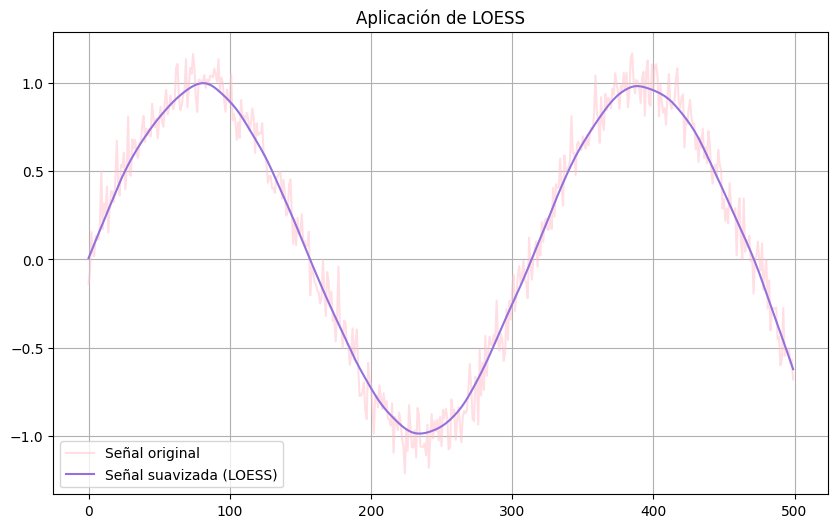

In [4]:
# Ejemplo de uso para una señal de ejemplo
signal = np.sin(np.linspace(0, 10, 500)) + np.random.normal(0, 0.1, 500)
smoothed_signal = apply_robust_loess(signal, frac=0.1)

plt.figure(figsize=(10, 6))
plt.plot(signal, label='Señal original', alpha=0.5, color="pink")
plt.plot(smoothed_signal, label='Señal suavizada (LOESS)', color="mediumpurple")
plt.grid(True)
plt.legend()
plt.title('Aplicación de LOESS')
plt.show()

**Non-Local Means (NLM)** [2]

Non-Local Means (NLM) es un método avanzado de reducción de ruido que se enfoca en preservar los detalles finos de la señal, como texturas y patrones repetitivos, mientras elimina el ruido. A diferencia de los filtros convencionales que consideran solo los valores locales para el suavizado, NLM se basa en la similitud entre puntos en toda la señal, utilizando ventanas de búsqueda que capturan la estructura y características específicas de la señal.

Aplicación y uso:

*  Para cada punto en la señal, se selecciona una ventana de búsqueda que define el área alrededor del punto 𝑖 donde se evaluará la similitud con otros puntos.

* Dentro de esta ventana, se comparan pequeñas subventanas o plantillas de la señal. La similitud entre estas se mide usando una métrica, comúnmente la distancia euclidiana, que cuantifica qué tan similares son en términos de intensidad o forma.

* Los valores de los puntos similares se promedian, ponderando más aquellos que son más parecidos al punto central, lo que permite un suavizado que mantiene las características distintivas de la señal.

NLM es apropiado para señales como el ECG, donde es importante reducir el ruido sin perder detalles esenciales. Este método mantiene los elementos importantes de la señal, como picos o patrones específicos, a diferencia de otros métodos de reducción de ruido que pueden suavizar en exceso y eliminar información relevante.

In [5]:
def apply_non_local_means(signal, h=40, template_window_size=15, search_window_size=35):
    # Guardar los valores mínimo y máximo de la señal original para la rescalación
    min_val = signal.min()
    max_val = signal.max()

    # Normalizar la señal al rango de 0 a 255 y convertir a uint8
    signal_uint8 = cv2.normalize(signal, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    signal_reshaped = signal_uint8.reshape(-1, 1)  # Formato de imagen (1 columna)

    # Aplicar el filtro NLM con parámetros ajustados
    denoised_signal = cv2.fastNlMeansDenoising(
        signal_reshaped, None, h, template_window_size, search_window_size
    )

    # Rescalar la señal filtrada al rango original
    denoised_signal = (denoised_signal / 255.0) * (max_val - min_val) + min_val
    return denoised_signal.flatten()

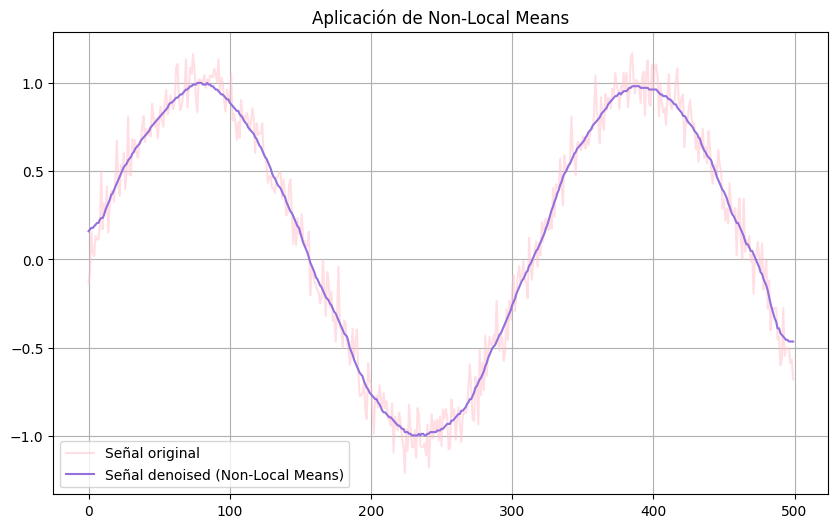

In [6]:
# Aplicar el filtro con los nuevos parámetros
nlm_denoised_signal = apply_non_local_means(signal)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(signal, label='Señal original', alpha=0.5, color="pink")
plt.plot(nlm_denoised_signal, label='Señal denoised (Non-Local Means)', color='mediumpurple')
plt.grid(True)
plt.legend()
plt.title('Aplicación de Non-Local Means')
plt.show()

# 2. Descargar los datos ECGData.zip de:

https://figshare.com/collections/ChapmanECG/4560497/1

In [7]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Bioseñales/Proyecto 2/Diagnostics.xlsx'
df = pd.read_excel(file_path)

# Filtrar los registros de Sinus Bradycardia (SB) y Atrial Fibrillation (AFIB) en la columna 'Rhythm'
filtered_data = df[df['Rhythm'].isin(['SB', 'AFIB'])]

# Guardar el archivo filtrado en un nuevo CSV
filtered_data.to_csv('/content/drive/MyDrive/Bioseñales/Proyecto 2/Filtered_Diagnostics.csv', index=False)
filtered_data

Mounted at /content/drive


,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9897,MUSE_20180114_134724_10000,SB,LVHV,56,FEMALE,56,56,88,444,428,49,62,9,219,263,441
9900,MUSE_20180113_122544_20000,SB,NONE,38,FEMALE,56,56,88,434,418,69,54,10,218,262,435
9902,MUSE_20180114_074720_85000,SB,NONE,55,FEMALE,57,57,94,414,402,-4,1,10,212,259,419
9903,MUSE_20180115_131524_93000,AFIB,RBBB TWC,70,MALE,93,82,130,386,479,61,194,15,225,290,418


# 3. Consulta de otros tipos de señales wavelet

**1. Wavelet Daubechies (db):**
  
  Las wavelets Daubechies son una familia de funciones matemáticas especialmente diseñadas para analizar y procesar señales como el ECG. Esta wavelet es muy popular porque es capaz de captar los patrones importantes de una señal ECG, como los complejos QRS (las partes puntiagudas de la onda que representan la actividad eléctrica principal del corazón) y los intervalos QT (que muestran el tiempo de actividad eléctrica en los ventrículos). En análisis de ECG, estas wavelets se aplican en escalas específicas (por ejemplo, j=4 y j=6), lo cual ayuda a "descomponer" la señal en distintos niveles de detalle [3].

  Con el proceso de descomposición, es posible observar detalles o características de la señal en diferentes niveles de profundidad, lo que permite eliminar el ruido sin afectar demasiado las características importantes. Esto es importante para estudiar señales cardíacas, donde los detalles del complejo QRS son de interés.

**2. Wavelet Symlets:**

 Las wavelets Symlets son una variante de las wavelets Daubechies, pero son más simétricas. La simetría en una wavelet ayuda a reducir la distorsión de fase, que se refiere a una pequeña desviación o cambio en el tiempo en que los picos de la señal aparecen en la onda filtrada. Esta propiedad puede ser beneficiosa para ciertas aplicaciones donde la forma original de la señal es importante, pero tiene sus limitaciones en el análisis de ECG. Aunque las Symlets pueden ayudar a reducir esa distorsión, en estudios previos no fueron tan precisas como las wavelets Daubechies (db3) para identificar los complejos QRS en la señal ECG. Esto significa que, aunque las Symlets pueden ser útiles en algunos casos, es posible que no detecten tan bien los picos importantes de una señal cardíaca en comparación con las Daubechies [4].

 **3. Wavelet Coiflet (coif1):**

  Las wavelets Coiflet (en particular, coif1) son una tercera familia de wavelets que ofrecen una precisión notable en el análisis de señales. Tienen ciertas propiedades matemáticas que les permiten capturar detalles más finos, lo cual es ideal para estudiar señales complejas como el ECG. Las Coiflets sirven para detectar los complejos QRS y eliminar el ruido en la señal, destacándose en situaciones donde es importante capturar hasta las variaciones más pequeñas en la señal, como cuando se necesita observar detalles de actividad cardíaca sutil [4].

Cada tipo de wavelet tiene fortalezas y limitaciones, y la elección adecuada depende de lo que se desea observar en la señal y del nivel de precisión necesario. Las Daubechies son especialmente eficaces para el ECG debido a su capacidad de identificar características clave como los complejos QRS sin alterar mucho la señal original. Las Coiflets, por otro lado, ofrecen un análisis más detallado para capturar variaciones pequeñas en la señal. Las Symlets, aunque menos precisas en algunos análisis de ECG, aportan una ventaja de simetría que puede ser útil para reducir la distorsión de fase en otras aplicaciones.

In [8]:
# Función para calcular el umbral
def threshold(coeff):
    num_samples = 0
    for i in range(len(coeff)):
        num_samples += coeff[i].shape[0]

    thr = np.sqrt(2 * (np.log(num_samples)))
    return thr

# Función para calcular el ruido blanco en los detalles
def wnoisest(coeff):
    # Estimación de la desviación estándar para cada nivel de detalle
    s = []
    for detail_coeff in coeff:
        sigma = np.median(np.abs(detail_coeff)) / 0.6745
        s.append(sigma)
    return s

# Función para aplicar el umbral y la ponderación en los detalles
def wthresh(coeff):
    y = []
    s = wnoisest(coeff)
    thr = threshold(coeff)
    for i in range(len(coeff)):
        y.append(np.multiply(coeff[i], np.abs(coeff[i]) > (thr * s[i])))
    return thr, s, y

# Modificar la función para devolver solo la señal reconstruida
def apply_wavelet_thresholding(signal, wavelet='db4'):
    level = 4
    # Descomposición de la señal
    data_wavelet = pywt.wavedec(signal, wavelet, level)

    # Separar la aproximación y los detalles
    approximation = data_wavelet[0]
    details = data_wavelet[1:]

    # Aplicar la función de umbralización y ponderación
    thr, s, details_t = wthresh(details)

    # Reconstruir la lista de coeficientes completa con los detalles umbralizados
    coeff = [approximation] + details_t

    # Reconstrucción de la señal desde los coeficientes umbralizados
    reconstructed_signal = pywt.waverec(coeff, wavelet)

    # Asegurarnos de que la señal reconstruida sea un array de una dimensión
    reconstructed_signal = np.asarray(reconstructed_signal)

    # Si la longitud de la señal reconstruida es diferente a la señal original, ajustarla
    if len(reconstructed_signal) > len(signal):
        reconstructed_signal = reconstructed_signal[:len(signal)]

    return reconstructed_signal  # Devolver solo la señal reconstruida

# 4. Escoger 10 señales al azar para análisis de flujos de filtrado

Dado que el archivo ECGData.zip es demasiado pesado, se extraen y se filtran los datos de cada archivo CSV de manera local, obteniendo únicamente la segunda derivada de cada uno. Una vez procesados, los datos filtrados se cargaron en Google Drive para continuar trabajando en el entorno de Google Colab.

**Código utilizado:**
```
import pandas as pd
import zipfile

# Rutas de los archivos
ruta_csv = r'C:\Users\ayepe\OneDrive - Universidad de Antioquia\UDEA\SEMESTRE IX\Bioseñales\Proyecto2\Filtered_Diagnostics.csv'
ruta_zip = r'C:\Users\ayepe\OneDrive - Universidad de Antioquia\UDEA\SEMESTRE IX\Bioseñales\Proyecto3\ECGData.zip'

# Leer el archivo Filtered_Diagnostics.csv
filtered_diagnostics = pd.read_csv(ruta_csv)

# Obtener la lista de archivos y la columna de Rhythm
archivos_necesarios = filtered_diagnostics['FileName'].values
rhythms = filtered_diagnostics['Rhythm'].values  # Aseguramos que existe la columna Rhythm

# Lista para almacenar los datos de la segunda derivada de 5 archivos SB y 5 AFIB
datos_combinados = []

# Contadores para limitar a 5 archivos de cada ritmo
contador_SB = 0
contador_AFIB = 0
max_archivos = 5

# Abrir el archivo ZIP
with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
    # Obtener la lista de todos los archivos en el zip, considerando la carpeta interna
    archivos_zip = zip_ref.namelist()

    # Recorrer los archivos que están en la lista de Filtered_Diagnostics
    for i, archivo in enumerate(archivos_necesarios):
        if contador_SB >= max_archivos and contador_AFIB >= max_archivos:
            break  # Salir del bucle si ya tenemos los 5 archivos de cada ritmo

        # Buscar el archivo dentro de la carpeta ECGData
        archivo_csv = f'ECGData/{archivo}.csv'
        if archivo_csv in archivos_zip:
            # Leer el archivo CSV directamente desde el zip sin encabezados
            with zip_ref.open(archivo_csv) as f:
                datos = pd.read_csv(f, delimiter=',', header=0, names=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'])

                # Extraer la columna II (Segunda derivada)
                segunda_derivada = ','.join(map(str, datos['II'].values))

                # Clasificar y almacenar los datos si es SB o AFIB, y no excede el máximo permitido
                if rhythms[i] == 'SB' and contador_SB < max_archivos:
                    datos_combinados.append({'FileName': archivo, 'Rhythm': rhythms[i], 'II_Derivada': segunda_derivada})
                    contador_SB += 1
                elif rhythms[i] == 'AFIB' and contador_AFIB < max_archivos:
                    datos_combinados.append({'FileName': archivo, 'Rhythm': rhythms[i], 'II_Derivada': segunda_derivada})
                    contador_AFIB += 1

# Crear un DataFrame con los resultados combinados
df_combinado = pd.DataFrame(datos_combinados)

# Guardar el DataFrame en un archivo CSV
df_combinado.to_csv('II_Derivada_10señales.csv', index=False)

print("Proceso completado. Datos guardados en 'II_Derivada_10señales.csv'.")

```



### Segunda derivada de 10 señales

In [9]:
# Rutas del archivo CSV
ruta = '/content/drive/MyDrive/Bioseñales/Proyecto 3/II_Derivada_10señales.csv'

# Leer el archivo CSV
df_II = pd.read_csv(ruta)
df_II

,FileName,Rhythm,II_Derivada
0,MUSE_20180113_171327_27000,AFIB,"263.52,263.52,263.52,263.52,244.0,234.24,224.4..."
1,MUSE_20180112_073319_29000,SB,"9.76,-19.52,-19.52,4.88,4.88,-9.76,-24.4,-29.2..."
2,MUSE_20180113_121940_44000,SB,"107.36,107.36,107.36,107.36,92.72,87.84,82.96,..."
3,MUSE_20180112_120347_79000,SB,"-68.32,-68.32,-68.32,-68.32,-58.56,-58.56,-58...."
4,MUSE_20180114_075026_69000,AFIB,"-156.16,-112.24,-117.12,-102.48,-73.2,-92.72,-..."
5,MUSE_20180114_075128_92000,SB,"-112.24,-97.6,-92.72,-92.72,-87.84,-92.72,-92...."
6,MUSE_20180118_174026_42000,SB,"-175.68,-165.92,-156.16,-156.16,-146.4,-141.52..."
7,MUSE_20180113_133901_16000,AFIB,"-78.08,-78.08,-78.08,-78.08,-87.84,-87.84,-87...."
8,MUSE_20180116_123940_90000,AFIB,"165.92,175.68,146.4,126.88,117.12,136.64,209.8..."
9,MUSE_20180114_075003_61000,AFIB,"-24.4,-4.88,-24.4,-29.28,-39.04,-24.4,-24.4,-3..."


Diagrama de Bode

<ipython-input-10-e7f6f220dcd5>:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freq, 20 * np.log10(abs(h)), label=f"Orden {order}")


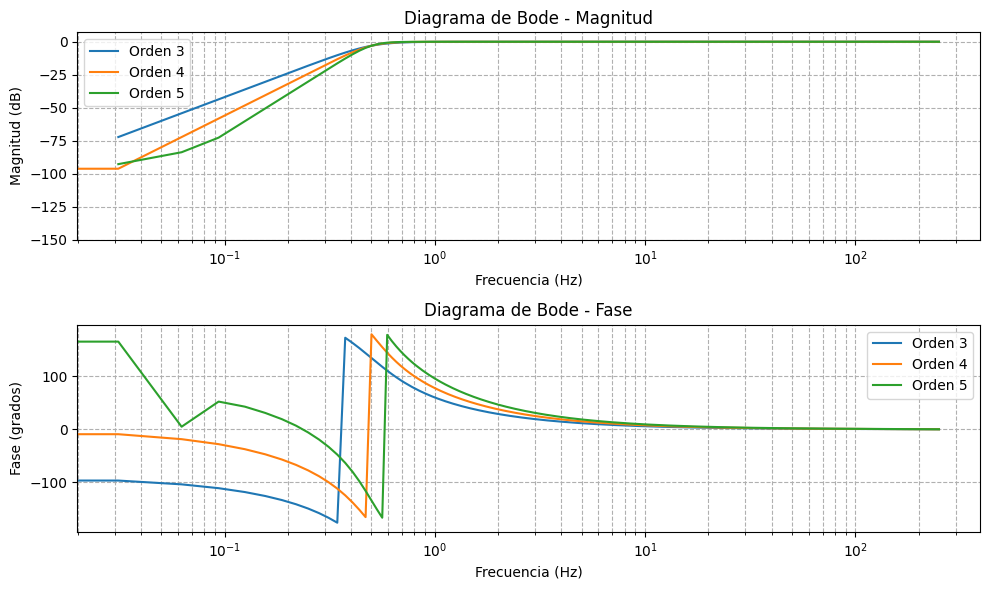

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import iirfilter, freqz

# Parámetros del filtro
fs = 500  # Frecuencia de muestreo en Hz
fc = 0.5  # Frecuencia de corte en Hz
orders = [3, 4, 5]  # Diferentes órdenes a analizar

# Crear el diagrama de Bode para diferentes órdenes
plt.figure(figsize=(10, 6))
for order in orders:
    # Diseño del filtro IIR pasa-altas
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = iirfilter(order, normal_cutoff, btype='high', ftype='butter', analog=False)

    # Calcular la respuesta en frecuencia
    w, h = freqz(b, a, worN=8000)
    freq = w * fs / (2 * np.pi)

    # Graficar magnitud (en dB) y fase
    plt.subplot(2, 1, 1)
    plt.plot(freq, 20 * np.log10(abs(h)), label=f"Orden {order}")
    plt.xscale('log')
    plt.title('Diagrama de Bode - Magnitud')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Magnitud (dB)')
    plt.grid(True, which='both', linestyle='--')

    plt.subplot(2, 1, 2)
    plt.plot(freq, np.angle(h, deg=True), label=f"Orden {order}")
    plt.xscale('log')
    plt.title('Diagrama de Bode - Fase')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Fase (grados)')
    plt.grid(True, which='both', linestyle='--')

# Ajustar y mostrar las leyendas
plt.subplot(2, 1, 1)
plt.legend()
plt.subplot(2, 1, 2)
plt.legend()
plt.tight_layout()
plt.show()


El orden 4 fue seleccionado para el diseño del filtro IIR, ya que ofrece un balance entre una buena atenuación de frecuencias no deseadas y una mínima distorsión de fase, según el análisis del diagrama de Bode. A diferencia del orden 3, el filtro de orden 4 logra una transición más definida y una mejor atenuación, mientras que evita las distorsiones de fase significativas que introduce un filtro de orden 5.

# Flujo 1

 ### **1.** Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [11]:
def aplicar_filtro_pasa_altas(datos, fs=500, fc=0.5, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = iirfilter(order, normal_cutoff, btype='high', ftype='butter', analog=False)
    return filtfilt(b, a, datos)

In [12]:
# Función para aplicar el filtro pasa-altas a una columna específica del DataFrame
def apply_highpass_filter(df, column_name='II_Derivada'):
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )

    # Aplicar el filtro pasa-altas a cada fila
    df[f'Pasa_altas_IIR'] = df[column_name].apply(lambda x: aplicar_filtro_pasa_altas(x))

    return df

###**2.** Filtro wavelet modificado del punto 3

In [13]:
def apply_wavelet_transform(df, column_name='Pasa_altas_IIR', wavelet='db4'):
  # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar la transformación wavelet y guardar la señal reconstruida
    df['wavelet'] = df[column_name].apply(lambda x: apply_wavelet_thresholding(x, wavelet))

    return df


### **3**. Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [14]:
def aplicar_filtro_pasabajas(datos, fs=500, fc=50, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = iirfilter(order, normal_cutoff, btype='low', ftype='butter', analog=False)
    return filtfilt(b, a, datos)

In [15]:
# Función para aplicar el filtro pasabajas a una columna específica del DataFrame
def apply_lowpass_filter(df, column_name='wavelet'):
  # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar el filtro pasabajas a cada fila
    df[f'Pasa_bajas_IIR'] = df[column_name].apply(lambda x: aplicar_filtro_pasabajas(x))

    return df

# Dataframe - Flujo 1:

In [16]:
df_II_1 = df_II.copy()

# Aplicar los filtros y transformadas al DataFrame
df_II_1 = apply_highpass_filter(df_II_1, column_name='II_Derivada')
df_II_1 = apply_wavelet_transform(df_II_1, column_name='Pasa_altas_IIR', wavelet='db4')
df_II_1 = apply_lowpass_filter(df_II_1, column_name='wavelet')

# Mostrar los primeros registros para verificar
df_II_1.head()

,FileName,Rhythm,II_Derivada,Pasa_altas_IIR,wavelet,Pasa_bajas_IIR
0,MUSE_20180113_171327_27000,AFIB,"[263.52, 263.52, 263.52, 263.52, 244.0, 234.24...","[-47.86755841322977, -46.783792166942646, -45....","[-47.99113693537241, -43.77710160894781, -39.4...","[-47.845373613569876, -42.72818421417858, -37...."
1,MUSE_20180112_073319_29000,SB,"[9.76, -19.52, -19.52, 4.88, 4.88, -9.76, -24....","[3.005397724407274, -26.17488393485941, -26.07...","[-3.5527980222765145, -3.545535217322373, -3.5...","[-3.55286636116924, -3.545416454330295, -3.537..."
2,MUSE_20180113_121940_44000,SB,"[107.36, 107.36, 107.36, 107.36, 92.72, 87.84,...","[23.844221959729687, 24.182388645907565, 24.52...","[-18.716856526126318, -38.11139233578781, -33....","[-18.71521809706024, -24.8828969775553, -30.14..."
3,MUSE_20180112_120347_79000,SB,"[-68.32, -68.32, -68.32, -68.32, -58.56, -58.5...","[-14.225045062256957, -14.404539325093706, -14...","[-9.013385607771681, -5.058809589312786, -5.26...","[-9.014464317593811, -7.590923792662666, -6.36..."
4,MUSE_20180114_075026_69000,AFIB,"[-156.16, -112.24, -117.12, -102.48, -73.2, -9...","[-63.000649292880965, -19.463928601595057, -24...","[10.50926819949224, 10.993567793231078, 11.520...","[10.540166363054103, 11.172216354193395, 11.78..."


### Comparaciones de los diferentes filtros

* Original vs filtro pasa-altas IIR



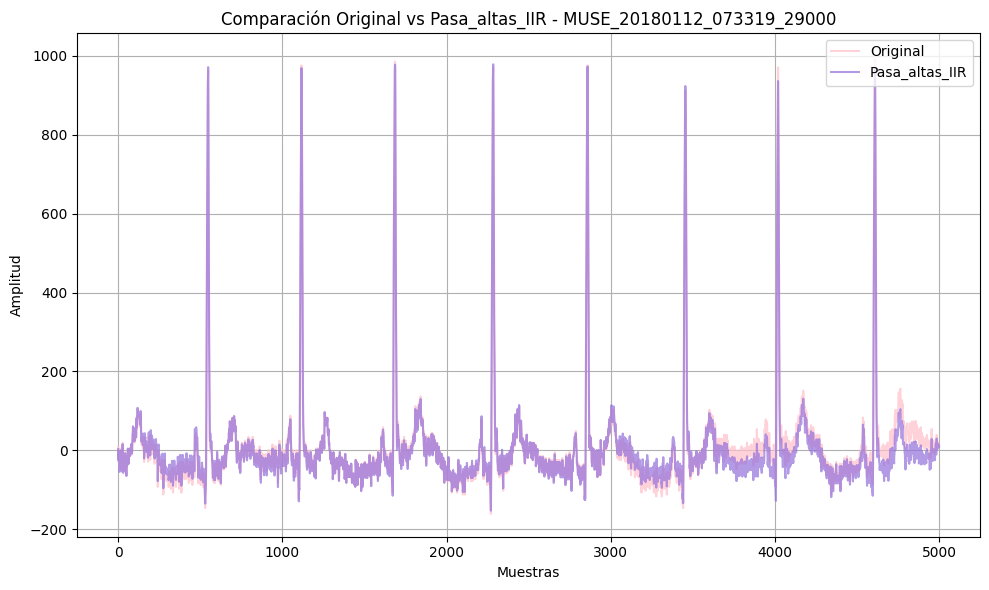

In [17]:
# Selecciona la primera fila
file_index = 1

# Extraer los valores de 'II_Derivada' y 'Detrended II_Derivada' para la fila 1
original_signal = df_II_1.iloc[file_index]['II_Derivada']
filtered_signal = df_II_1.iloc[file_index]['Pasa_altas_IIR']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original', alpha=0.7, color='pink')
plt.plot(filtered_signal, label='Pasa_altas_IIR', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación Original vs Pasa_altas_IIR - {df_II_1.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


Se elige un filtro IIR (Infinite Impulse Response) debido a que, para una misma especificación de respuesta, puede lograr el efecto deseado con un menor número de coeficientes que un filtro FIR (Finite Impulse Response). Esto permite una estructura de filtro más compacta, lo cual puede ser de gran ventaja en aplicaciones de procesamiento en tiempo real o en sistemas con limitaciones de memoria [5].

La frecuencia de corte de 0.5 Hz es una elección común para reducir el ruido de baja frecuencia, como las fluctuaciones de la línea de base en señales ECG, sin afectar componentes críticos como los complejos QRS. Un filtro de orden 4 proporciona una atenuación adecuada de las frecuencias no deseadas mientras mantiene la forma general de la señal.

Aunque en la programación moderna no hay una gran diferencia en la implementación de un filtro IIR frente a un FIR, los IIR son preferidos en algunos casos porque pueden cumplir con los requisitos de respuesta de frecuencia sin necesidad de un alto orden, lo que ayuda a optimizar el uso de recursos, especialmente en sistemas de procesamiento de señales en tiempo real.

* Original vs IIR + Wavelet

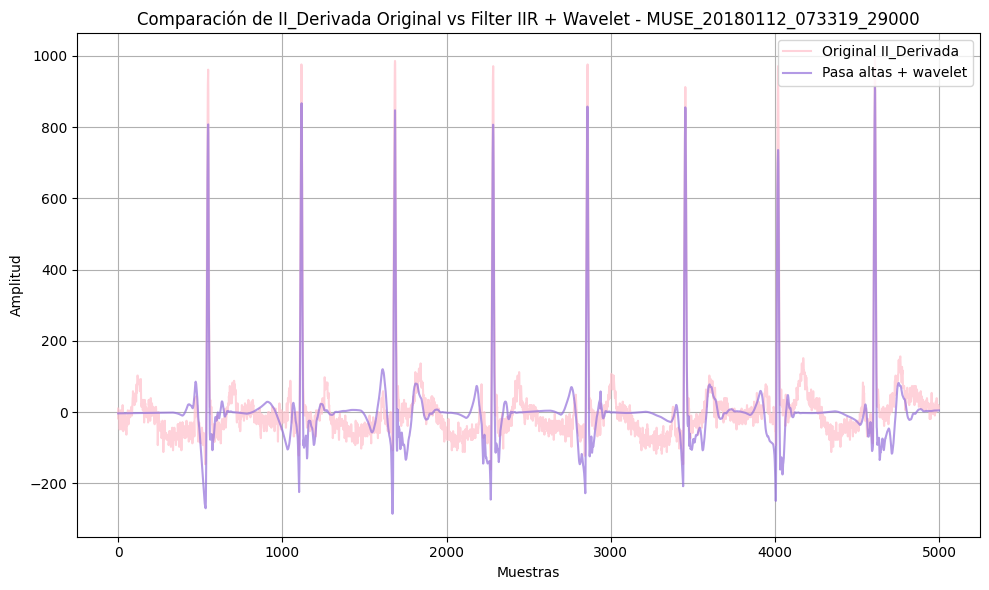

In [18]:
file_index = 1

original_signal = df_II_1.iloc[file_index]['II_Derivada']
wavelet_signal = df_II_1.iloc[file_index]['wavelet']

if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original II_Derivada', alpha=0.7, color='pink')
plt.plot(wavelet_signal, label='Pasa altas + wavelet', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación de II_Derivada Original vs Filter IIR + Wavelet - {df_II_1.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

* Original vs Pasa-altas + wavelet + Pasa-bajas

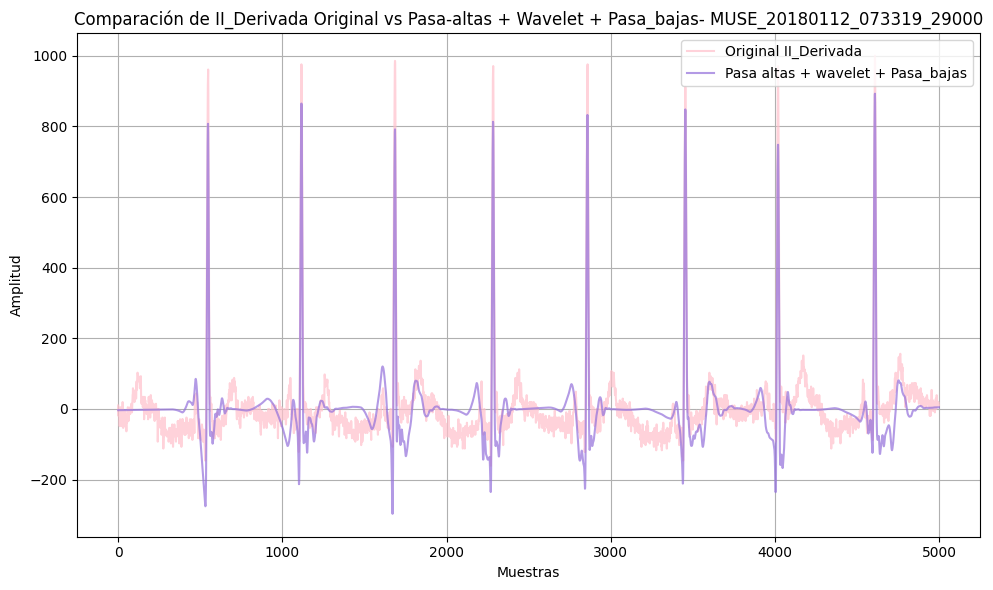

In [19]:
file_index = 1

original_signal = df_II_1.iloc[file_index]['II_Derivada']
wavelet_signal = df_II_1.iloc[file_index]['Pasa_bajas_IIR']

if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original II_Derivada', alpha=0.7, color='pink')
plt.plot(wavelet_signal, label='Pasa altas + wavelet + Pasa_bajas', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación de II_Derivada Original vs Pasa-altas + Wavelet + Pasa_bajas- {df_II_1.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


El gráfico muestra una comparación entre la señal original de ECG y la señal procesada utilizando el Flujo 1, que incluye un filtro pasa-altas, un filtro wavelet y un filtro pasa-bajas. En la señal procesada se observa una reducción significativa de las variaciones de baja frecuencia presentes en la señal original, lo cual indica que el filtro pasa-altas ha sido efectivo para eliminar el ruido de baja frecuencia, como las fluctuaciones de la línea de base que pueden estar causadas por el movimiento del paciente o por variaciones en el nivel de la señal.

La señal procesada mantiene los componentes de alta frecuencia característicos de los complejos QRS, aunque con ciertas diferencias en la amplitud en comparación con la señal original. Los picos correspondientes a los complejos QRS siguen siendo claramente visibles en la señal procesada, lo cual sugiere que los filtros aplicados han preservado las características más importantes de la señal ECG para su análisis clínico. Además, el uso del filtro wavelet y del filtro pasa-bajas ha reducido el ruido de alta frecuencia, suavizando algunas de las variaciones rápidas y mejorando la claridad de la señal sin alterar significativamente la forma del complejo QRS.

Sin embargo, la señal procesada muestra una amplitud algo menor en comparación con la original, lo cual podría deberse a la combinación de filtros, que atenúan ligeramente algunas características de la señal. Esto es relevante, ya que una disminución excesiva en la amplitud podría limitar la interpretación de ciertos aspectos clínicos importantes en la señal ECG.

# Flujo 2

### **1.** Detrend

In [20]:
# Función para aplicar detrend a una señal
def apply_detrend(df, column_name='II_Derivada'):

     # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )

    # Aplicar detrend a cada fila
    df[f'Detrended'] = df[column_name].apply(lambda x: detrend(x))

    return df

### **2.** Filtro wavelet modificado del punto 3

In [21]:
def apply_wavelet_transform(df, column_name='Pasa_altas_IIR', wavelet='db4'):
  # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar la transformación wavelet y guardar la señal reconstruida
    df['wavelet'] = df[column_name].apply(lambda x: apply_wavelet_thresholding(x, wavelet))

    return df

### **3.** Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [22]:
def aplicar_filtro_pasabajas(datos, fs=500, fc=50, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = iirfilter(order, normal_cutoff, btype='low', ftype='butter', analog=False)
    return filtfilt(b, a, datos)

In [23]:
# Función para aplicar el filtro pasabajas a una columna específica del DataFrame
def apply_lowpass_filter(df, column_name='wavelet'):
  # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar el filtro pasabajas a cada fila
    df[f'Pasa_bajas_IIR'] = df[column_name].apply(lambda x: aplicar_filtro_pasabajas(x))

    return df

# Dataframe - Flujo 2

In [24]:
df_II_2 = df_II.copy()
# Aplicar los filtros y transformadas al DataFrame
df_II_2 = apply_detrend(df_II_2, column_name='II_Derivada')
df_II_2 = apply_wavelet_transform(df_II_2, column_name='Detrended', wavelet='db4')
df_II_2 = apply_lowpass_filter(df_II_2, column_name='wavelet')

# Mostrar los primeros registros para verificar
df_II_2.head()

,FileName,Rhythm,II_Derivada,Detrended,wavelet,Pasa_bajas_IIR
0,MUSE_20180113_171327_27000,AFIB,"[263.52, 263.52, 263.52, 263.52, 244.0, 234.24...","[250.89648040311937, 250.90157924032556, 250.9...","[205.50237638055114, 208.80214713632856, 219.4...","[205.61254817819338, 208.72370706933575, 209.4..."
1,MUSE_20180112_073319_29000,SB,"[9.76, -19.52, -19.52, 4.88, 4.88, -9.76, -24....","[22.144217511697654, -7.142893776764714, -7.15...","[-6.468225925536911, -6.471820899553274, -6.47...","[-6.468201104046506, -6.471763818443676, -6.47..."
2,MUSE_20180113_121940_44000,SB,"[107.36, 107.36, 107.36, 107.36, 92.72, 87.84,...","[92.93355137612478, 92.94521620534017, 92.9568...","[46.85028615289242, 48.147634807195516, 37.804...","[46.83899294953554, 34.752787321096974, 22.334..."
3,MUSE_20180112_120347_79000,SB,"[-68.32, -68.32, -68.32, -68.32, -58.56, -58.5...","[-58.31947542651471, -58.32384973360552, -58.3...","[-39.37946407499978, -11.800541556169605, -3.4...","[-39.38020967817258, -28.183557572870825, -18...."
4,MUSE_20180114_075026_69000,AFIB,"[-156.16, -112.24, -117.12, -102.48, -73.2, -9...","[-147.3927811109778, -103.47817861403402, -108...","[-62.20573480227202, 57.00955770860065, 28.212...","[-62.17204562041892, -24.898779787992943, 6.72..."


### Comparaciónes de los diferentes filtros

* Original vs detrend

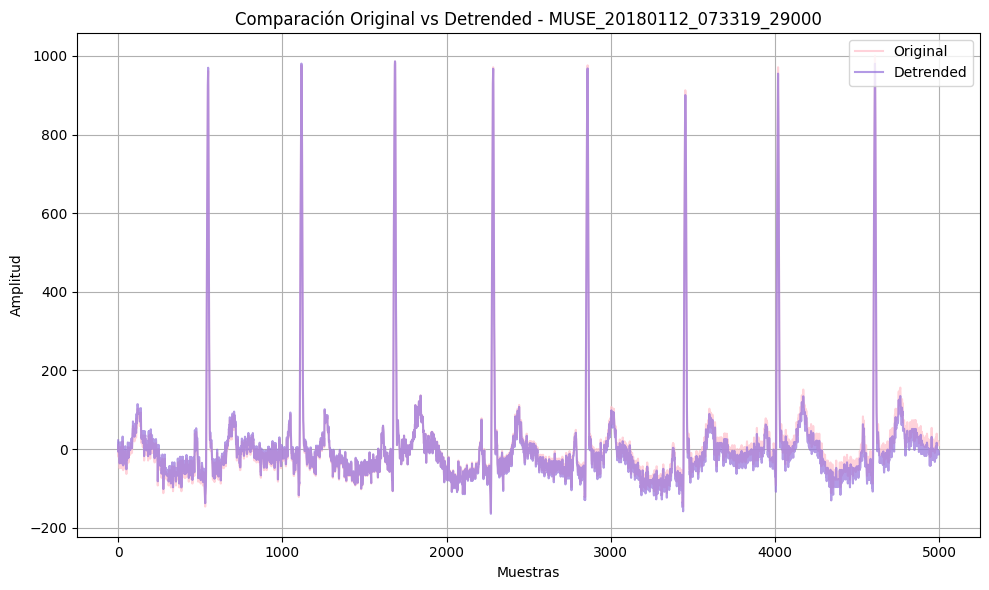

In [25]:
# Selecciona la primera fila
file_index = 1

# Extraer los valores de 'II_Derivada' y 'Detrended II_Derivada' para la fila 1
original_signal = df_II_2.iloc[file_index]['II_Derivada']
detrended_signal = df_II_2.iloc[file_index]['Detrended']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original', alpha=0.7, color='pink')
plt.plot(detrended_signal, label='Detrended', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación Original vs Detrended - {df_II_2.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

* Original vs Detrended + Wavelet

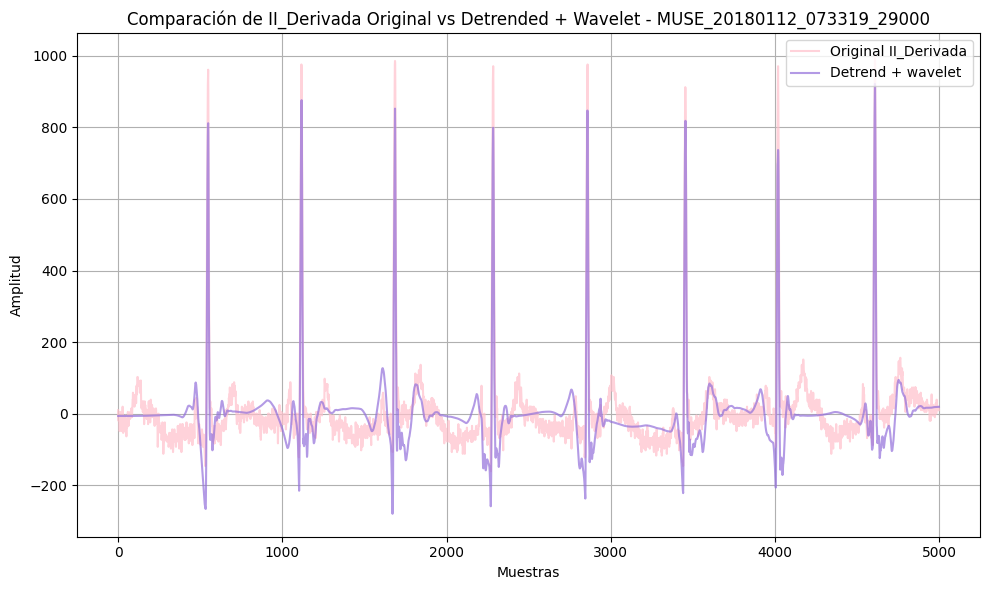

In [26]:
# Selecciona la primera fila
file_index = 1

# Extraer los valores de 'II_Derivada' y 'Detrended II_Derivada' para la fila 1
original_signal = df_II_2.iloc[file_index]['II_Derivada']
wavelet_signal = df_II_2.iloc[file_index]['wavelet']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original II_Derivada', alpha=0.7, color='pink')
plt.plot(wavelet_signal, label='Detrend + wavelet', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación de II_Derivada Original vs Detrended + Wavelet - {df_II_2.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

* Original vs Detrend + wavelet + pasabajas

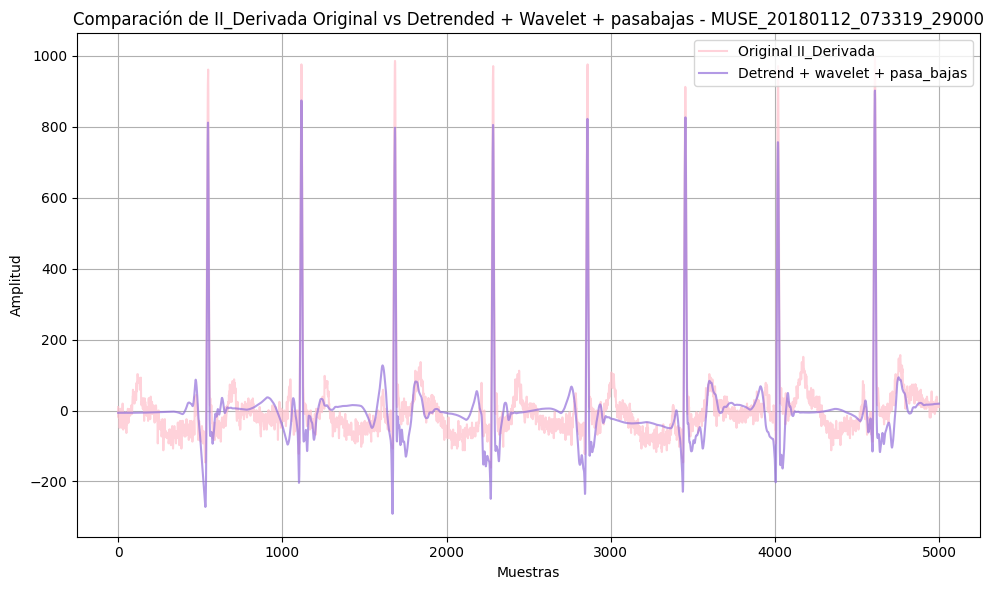

In [27]:
# Selecciona la primera fila
file_index = 1

# Extraer los valores de 'II_Derivada' y 'Detrended II_Derivada' para la fila 1
original_signal = df_II_2.iloc[file_index]['II_Derivada']
wavelet_signal = df_II_2.iloc[file_index]['Pasa_bajas_IIR']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original II_Derivada', alpha=0.7, color='pink')
plt.plot(wavelet_signal, label='Detrend + wavelet + pasa_bajas', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación de II_Derivada Original vs Detrended + Wavelet + pasabajas - {df_II_2.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

El gráfico muestra la comparación entre la señal original de ECG y la señal procesada utilizando el Flujo 2, que incluye un proceso de eliminación de tendencia (detrend), un filtro wavelet y un filtro pasa-bajas.

En la señal procesada, se observa una reducción de la línea de base y de las oscilaciones de baja frecuencia gracias al proceso de eliminación de tendencia (detrend), lo que permite obtener una señal centrada en cero sin las fluctuaciones lentas que pueden dificultar la interpretación de los elementos importantes de la señal ECG, como los complejos QRS. Este paso es apropiado para estabilizar la línea de base y, junto con el filtro wavelet, contribuye a una eliminación adicional de ruido, mejorando la claridad general de la señal sin perder los componentes importantes.

La señal resultante mantiene los detalles de alta frecuencia característicos de los complejos QRS, que son importantes para el análisis clínico de la señal ECG. Esto indica que el flujo ha sido efectivo en preservar las características principales de la señal mientras atenúa el ruido de fondo. Además, la aplicación del filtro pasa-bajas al final del flujo ayuda a reducir el ruido de alta frecuencia que pudiera permanecer, suavizando variaciones rápidas en la señal sin afectar la forma general del complejo QRS.

El uso de un filtro IIR se selecciona nuevamente por las mismas razones mencionadas anteriormente: su capacidad para lograr la respuesta de frecuencia deseada con un menor número de coeficientes en comparación con un filtro FIR. En este caso, se ha elegido un filtro de orden 4 ya que proporciona una atenuación adecuada de las frecuencias no deseadas sin introducir una distorsión significativa en la señal. Este orden es suficiente para eliminar el ruido de alta frecuencia mientras preserva las características esenciales de la señal ECG, como los complejos QRS, permitiendo una buena relación entre calidad de filtrado y eficiencia computacional. La frecuencia de corte del filtro pasa-bajas está diseñada para permitir el paso de los elementos importantes de la señal ECG, asegurando que la morfología y los picos críticos de la señal se mantengan claros y sin distorsión.

# Flujo 3

**1.** Filtro pasa-altas usando filtro IIR a 0.5 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [28]:
# Función para aplicar un filtro pasa-altas IIR a 0.5 Hz
def aplicar_filtro_pasa_altas(datos, fs=500, fc=0.5, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = iirfilter(order, normal_cutoff, btype='high', ftype='butter', analog=False)
    return filtfilt(b, a, datos)

In [29]:
# Función para aplicar el filtro pasa-altas a una columna específica del DataFrame
def apply_highpass_filter(df, column_name='II_Derivada'):
    # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )

    # Aplicar el filtro pasa-altas a cada fila
    df[f'Pasa_altas_IIR'] = df[column_name].apply(lambda x: aplicar_filtro_pasa_altas(x))

    return df

**2.** Filtrado pasabajas 50 Hz. Justificar la elección de parámetros y si se usa FIR o IIR

In [30]:
def aplicar_filtro_pasabajas(datos, fs=500, fc=50, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = fc / nyquist
    b, a = iirfilter(order, normal_cutoff, btype='low', ftype='butter', analog=False)
    return filtfilt(b, a, datos)

In [31]:
# Función para aplicar el filtro pasabajas a una columna específica del DataFrame
def apply_lowpass_filter(df, column_name='Pasa_altas_IIR'):
  # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar el filtro pasabajas a cada fila
    df[f'Pasa_bajas_IIR'] = df[column_name].apply(lambda x: aplicar_filtro_pasabajas(x))

    return df

#Dataframe - Flujo 3

In [32]:
df_II_3 = df_II.copy()
# Aplicar los filtros y transformadas al DataFrame
df_II_3 = apply_highpass_filter(df_II_3, column_name='II_Derivada')
df_II_3 = apply_lowpass_filter(df_II_3, column_name='Pasa_altas_IIR')

# Mostrar los primeros registros para verificar
df_II_3.head()

,FileName,Rhythm,II_Derivada,Pasa_altas_IIR,Pasa_bajas_IIR
0,MUSE_20180113_171327_27000,AFIB,"[263.52, 263.52, 263.52, 263.52, 244.0, 234.24...","[-47.86755841322977, -46.783792166942646, -45....","[-47.57115927517369, -45.28105808928203, -44.4..."
1,MUSE_20180112_073319_29000,SB,"[9.76, -19.52, -19.52, 4.88, 4.88, -9.76, -24....","[3.005397724407274, -26.17488393485941, -26.07...","[2.9787747742619746, -1.2487976149341453, -5.6..."
2,MUSE_20180113_121940_44000,SB,"[107.36, 107.36, 107.36, 107.36, 92.72, 87.84,...","[23.844221959729687, 24.182388645907565, 24.52...","[23.879346887602136, 22.607377395763304, 20.63..."
3,MUSE_20180112_120347_79000,SB,"[-68.32, -68.32, -68.32, -68.32, -58.56, -58.5...","[-14.225045062256957, -14.404539325093706, -14...","[-14.175078427539539, -12.326427486688496, -10..."
4,MUSE_20180114_075026_69000,AFIB,"[-156.16, -112.24, -117.12, -102.48, -73.2, -9...","[-63.000649292880965, -19.463928601595057, -24...","[-63.23071726637518, -41.19025924893047, -21.1..."


### Comparaciónes de los diferentes filtros

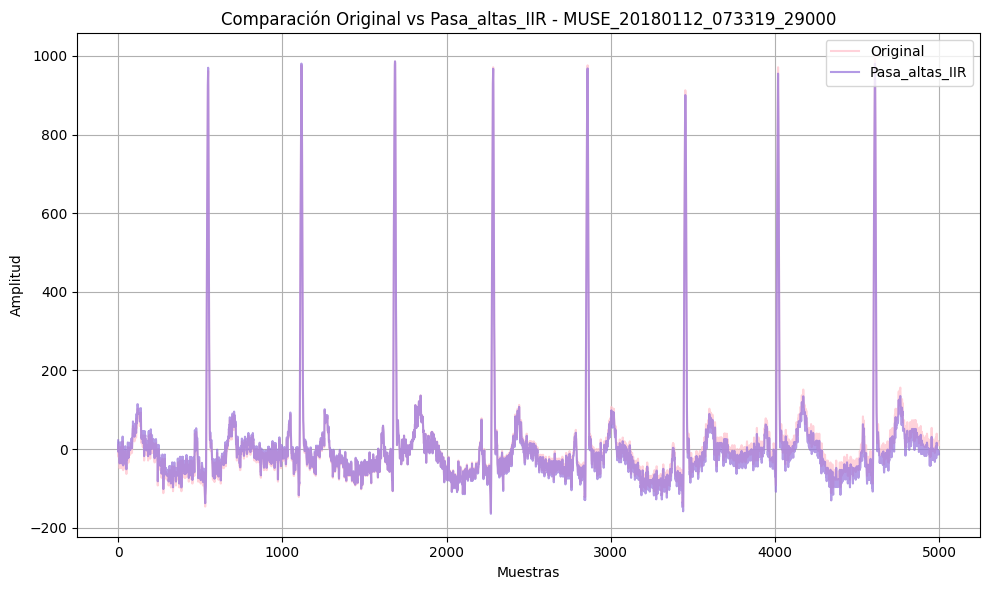

In [33]:
# Selecciona la primera fila
file_index = 1

# Extraer los valores de 'II_Derivada' y 'Detrended II_Derivada' para la fila 1
original_signal = df_II_3.iloc[file_index]['II_Derivada']
pasa_altas_signal = df_II_3.iloc[file_index]['Pasa_altas_IIR']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original', alpha=0.7, color='pink')
plt.plot(detrended_signal, label='Pasa_altas_IIR', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación Original vs Pasa_altas_IIR - {df_II_3.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

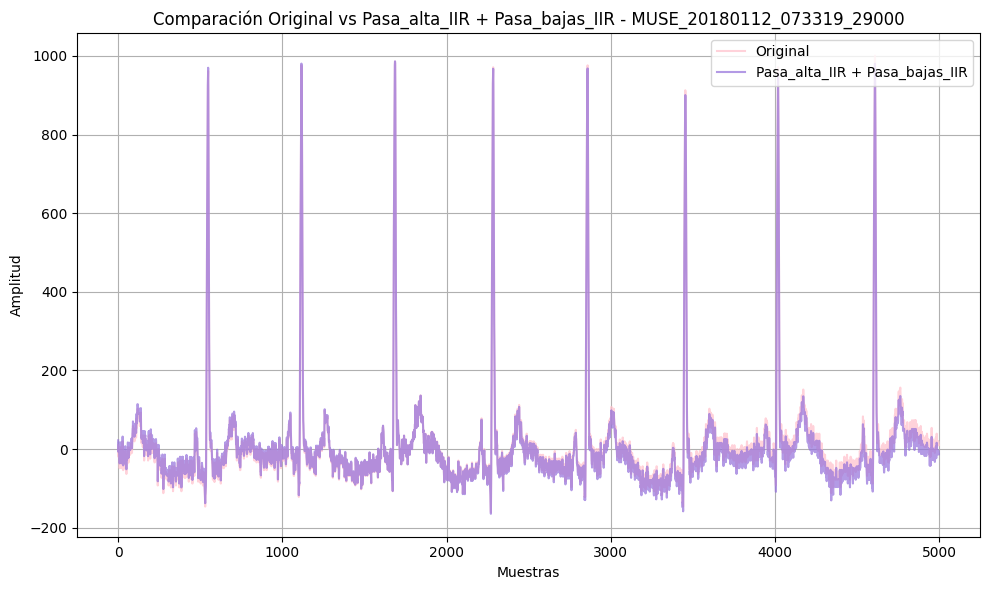

In [34]:
# Selecciona la primera fila
file_index = 1

# Extraer los valores de 'II_Derivada' y 'Detrended II_Derivada' para la fila 1
original_signal = df_II_3.iloc[file_index]['II_Derivada']
pasa_altas_signal = df_II_3.iloc[file_index]['Pasa_bajas_IIR']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(original_signal, str):
    original_signal = np.array([float(i) for i in original_signal.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(original_signal, label='Original', alpha=0.7, color='pink')
plt.plot(detrended_signal, label='Pasa_alta_IIR + Pasa_bajas_IIR', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Comparación Original vs Pasa_alta_IIR + Pasa_bajas_IIR - {df_II_3.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

En este gráfico, se compara una señal ECG original con una señal procesada mediante el flujo 3, que incluye un filtrado pasa altas y pasa bajas utilizando filtros IIR.

Para este flujo, se observa que el procesamiento no ha sido completamente efectivo en reducir las componentes de alta frecuencia. Se nota una gran cantidad de ruido, lo que afecta la calidad de la señal procesada. Idealmente, el flujo debería haber suavizado estas variaciones rápidas sin afectar las características esenciales de la señal ECG, pero en este caso, el filtrado no ha logrado eliminar las componentes de ruido.

El resultado indica que el filtrado aplicado no ha sido completamente efectivo para reducir el ruido de alta frecuencia en la señal procesada. Esto implica que el flujo de procesamiento podría beneficiarse de una estrategia complementaria que permita una mayor atenuación de las componentes de alta frecuencia sin afectar las características esenciales de la señal ECG.

# 5 - Describir los resultados obtenidos y decidir si el resto del procesamiento se hace con el flujo 1, el flujo 2 o el flujo 3

In [35]:
# Rutas del archivo CSV
ruta = '/content/drive/MyDrive/Bioseñales/Proyecto 3/II_Derivada_MUSE_20180112_073319_29000.csv'

# Leer el archivo CSV
df_MUSE = pd.read_csv(ruta)

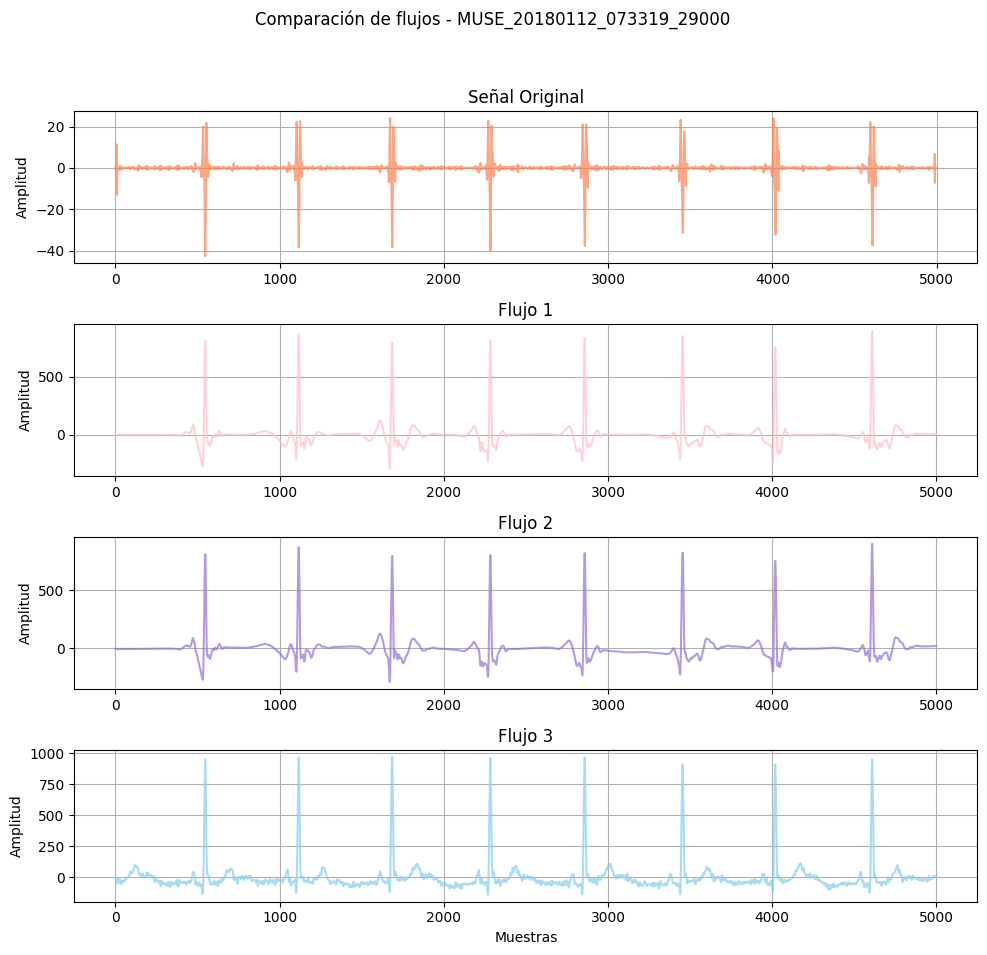

In [36]:
file_index = 1

flujo_1 = df_II_1.iloc[file_index]['Pasa_bajas_IIR']
flujo_2 = df_II_2.iloc[file_index]['Pasa_bajas_IIR']
flujo_3 = df_II_3.iloc[file_index]['Pasa_bajas_IIR']
flujo_original = df_MUSE['II_Derivada'].iloc[0]

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(flujo_original, str):
    flujo_original = np.array([float(i) for i in flujo_original.split(',')])

plt.figure(figsize=(10, 10))

# Configurar cada subplot con la señal original primero
plt.subplot(4, 1, 1)
plt.plot(flujo_original, color='coral', alpha=0.7)
plt.title('Señal Original')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(flujo_1, color='pink', alpha=0.7)
plt.title('Flujo 1')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(flujo_2, color='mediumpurple', alpha=0.7)
plt.title('Flujo 2')
plt.ylabel('Amplitud')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(flujo_3, color='skyblue', alpha=0.7)
plt.title('Flujo 3')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)

# Configuraciones adicionales
plt.suptitle(f'Comparación de flujos - {df_II_1.iloc[file_index]["FileName"]}')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Al comparar los resultados obtenidos con los flujos 1 y 2, no se observan diferencias visuales muy marcadas en la señal filtrada, ya que ambos logran reducir efectivamente el ruido y permiten una identificación clara de los complejos QRS. Sin embargo, el Flujo 2 presenta ventajas importantes que justifican su elección. Al aplicar un paso de detrend antes de cualquier otro filtrado, el Flujo 2 logra una eliminación más efectiva de la deriva de la línea base, lo que resulta en una señal más estable y facilita la identificación precisa de ondas de menor amplitud como las ondas P y T. Además, esta secuencia minimiza la distorsión de la señal al evitar el uso del filtro pasa-altas inicial, lo que permite que el filtrado posterior sea más eficiente sin comprometer la morfología del ECG. Como resultado, el Flujo 2 preserva mejor las características esenciales de la señal, siendo la opción más adecuada para un análisis diagnóstico preciso.

Por otro lado, el Flujo 3, aunque sigue se ve un poco más similar al que se utilizó en el artículo previo al que hacemos referencia, muestra resultados menos satisfactorios en comparación con los otros flujos. A pesar de eliminar algunas componentes de alta y baja frecuencia, la señal resultante aún presenta un nivel significativo de ruido, como se puede apreciar en el gráfico. Esto se traduce en una línea base inestable y en la presencia de oscilaciones residuales que dificultan la identificación precisa de las ondas P y T (mayormente). Al omitir el paso de detrend y del filtro wavelet en este flujo limita su capacidad para reducir los artefactos de alta frecuencia y estabilizar la señal, lo que compromete su utilidad para un análisis clínico preciso.

Por lo tanto se selecciona el flujo de filtrado # 2.


# 6 - Con el flujo seleccionado procesar todas las señales.

### Cargar archivos *completos*

In [37]:
# Rutas del archivo CSV
ruta_AFIB = '/content/drive/MyDrive/Bioseñales/Proyecto 3/II_Derivada_AFIB.csv'

# Leer el archivo CSV
df_II_AFIB = pd.read_csv(ruta_AFIB)

In [38]:
# Rutas del archivo CSV
ruta_SB = '/content/drive/MyDrive/Bioseñales/Proyecto 3/II_Derivada_SB.csv'

# Leer el archivo CSV
df_II_SB = pd.read_csv(ruta_SB)


In [39]:
df_Total = pd.concat([df_II_AFIB, df_II_SB])

In [40]:
def clean_derivada_column(value):
    # Verificar si el valor es una cadena y tiene comas
    if isinstance(value, str):
        # Separar por comas y eliminar el primer elemento
        elements = value.split(',')
        # Comprobar si hay al menos un elemento antes de eliminar
        if len(elements) > 1:
            return ','.join(elements[1:])  # Unir de nuevo excluyendo el primer elemento
    return value

# 2. Aplicar la función a la columna 'II_Derivada'
df_Total['II_Derivada'] = df_Total['II_Derivada'].apply(clean_derivada_column)

# 3. Convertir la columna a listas de números flotantes después de la limpieza
df_Total['II_Derivada'] = df_Total['II_Derivada'].apply(
    lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
)

# Verificar los primeros registros después de la limpieza
df_Total.head()

,FileName,Rhythm,II_Derivada
0,MUSE_20180113_171327_27000,AFIB,"[263.52, 263.52, 263.52, 263.52, 244.0, 234.24..."
1,MUSE_20180114_075026_69000,AFIB,"[-156.16, -112.24, -117.12, -102.48, -73.2, -9..."
2,MUSE_20180113_133901_16000,AFIB,"[-78.08, -78.08, -78.08, -78.08, -87.84, -87.8..."
3,MUSE_20180116_123940_90000,AFIB,"[165.92, 175.68, 146.4, 126.88, 117.12, 136.64..."
4,MUSE_20180114_075003_61000,AFIB,"[-24.4, -4.88, -24.4, -29.28, -39.04, -24.4, -..."


###Aplicar flujo 2 a todas las señales:

In [41]:
df_Totales = df_Total.copy()
df_Totales = apply_detrend(df_Totales, column_name='II_Derivada')
df_Totales = apply_wavelet_transform(df_Totales, column_name='Detrended', wavelet='db4')
df_Totales = apply_lowpass_filter(df_Totales, column_name='wavelet')

### Formula 1 - Detrend

In [42]:
# Función para aplicar detrend a una columna
def apply_detrend(df, column_name, new_column_name):
    # Convertir la columna en listas de floats si es necesario
    df[column_name] = df[column_name].apply(
        lambda x: np.array([float(i) for i in x.split(',')]) if isinstance(x, str) else x
    )
    # Aplicar detrend y almacenar en la nueva columna
    df[new_column_name] = df[column_name].apply(lambda x: detrend(x))
    return df

### Formula 2 - Compression

In [43]:
def compress_signal(signal):
    x_min = np.min(signal)  # Valor mínimo de la señal
    x_max = np.max(signal)  # Valor máximo de la señal
    compressed_signal = (signal - x_min) / (x_max - x_min)  # Fórmula de compresión
    return compressed_signal

In [44]:
# Función para aplicar compresión a una columna
def apply_compression(df, column_name, new_column_name):
    # Aplicar la compresión a cada fila de la columna especificada y almacenar en la nueva columna
    df[new_column_name] = df[column_name].apply(lambda x: compress_signal(x))
    return df

In [45]:
# 1. Aplicar el primer detrend a 'Pasa_bajas_IIR' y almacenar en 'detrend2'
df_Totales = apply_detrend(df_Totales, column_name='Pasa_bajas_IIR', new_column_name='detrend2')

# 2. Aplicar compresión a 'detrend2' y almacenar en 'compression'
df_Totales = apply_compression(df_Totales, column_name='detrend2', new_column_name='compression')

# 3. Aplicar el segundo detrend a 'compression' y almacenar en 'detrend3'
df_Totales = apply_detrend(df_Totales, column_name='compression', new_column_name='detrend3')

# Mostrar los primeros registros para verificar
df_Totales.head()

,FileName,Rhythm,II_Derivada,Detrended,wavelet,Pasa_bajas_IIR,detrend2,compression,detrend3
0,MUSE_20180113_171327_27000,AFIB,"[263.52, 263.52, 263.52, 263.52, 244.0, 234.24...","[250.89648040311937, 250.90157924032556, 250.9...","[205.50237638055114, 208.80214713632856, 219.4...","[205.61254817819338, 208.72370706933575, 209.4...","[205.37188366793976, 208.48320905341293, 209.2...","[0.7095607410325279, 0.7138029598479293, 0.714...","[0.2800197218582023, 0.2842619406736037, 0.285..."
1,MUSE_20180114_075026_69000,AFIB,"[-156.16, -112.24, -117.12, -102.48, -73.2, -9...","[-147.3927811109778, -103.47817861403402, -108...","[-62.20573480227202, 57.00955770860065, 28.212...","[-62.17204562041892, -24.898779787992943, 6.72...","[-63.387792361199274, -26.11434647237412, 5.51...","[0.3198051807804327, 0.37396650259058944, 0.41...","[-0.09210757253703705, -0.03794625072688029, 0..."
2,MUSE_20180113_133901_16000,AFIB,"[-78.08, -78.08, -78.08, -78.08, -87.84, -87.8...","[-50.500286848230374, -50.50498777607665, -50....","[-27.168508930761277, -27.03889989332766, -26....","[-27.169609040734354, -27.03833876471138, -26....","[-26.41878772790922, -26.287825992289665, -26....","[0.29269706039626175, 0.2930187102218204, 0.29...","[-0.06488611672679656, -0.0645644669012379, -0..."
3,MUSE_20180116_123940_90000,AFIB,"[165.92, 175.68, 146.4, 126.88, 117.12, 136.64...","[170.42171481223752, 180.18018280551132, 150.8...","[112.84667559650376, 129.47056022139355, 87.43...","[115.57271324512804, 87.95554683910855, 62.956...","[117.09137623732714, 89.47373267549229, 64.474...","[0.5146256369223287, 0.49099248412463536, 0.46...","[0.10019820770418858, 0.07656505490649529, 0.0..."
4,MUSE_20180114_075003_61000,AFIB,"[-24.4, -4.88, -24.4, -29.28, -39.04, -24.4, -...","[-25.158200359928014, -5.638189877687596, -25....","[-47.05252427311342, 22.104677475252657, 5.576...","[-47.05470977088211, -25.426636264192396, -7.0...","[-48.968566408583406, -27.340393935432026, -8....","[0.5069893422068161, 0.5281124310289342, 0.546...","[-0.04782500135063772, -0.02670191252851961, -..."


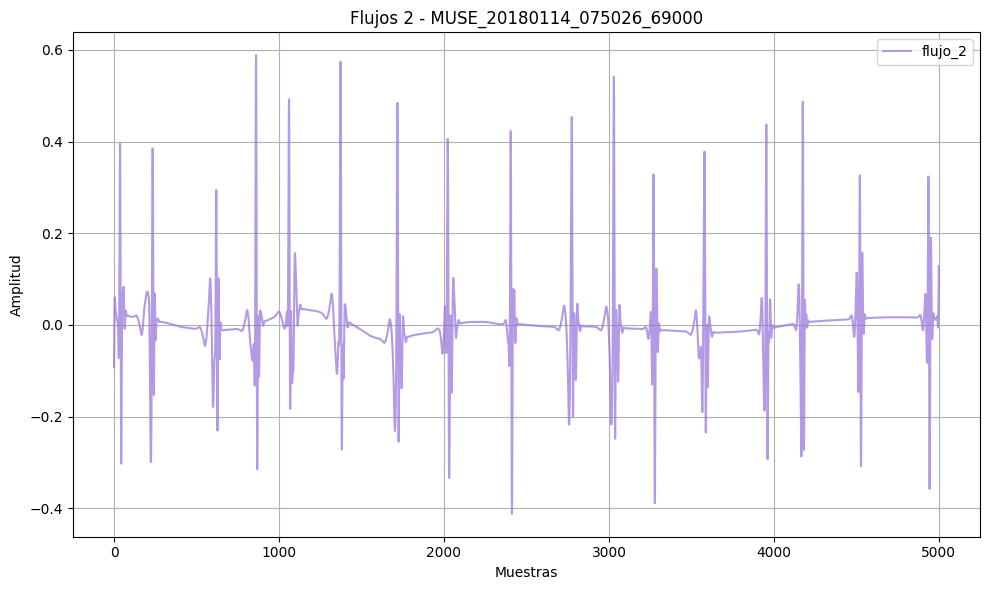

In [46]:
file_index = 1

flujo_2 = df_Totales.iloc[file_index]['detrend3']

# Convertir los valores de 'II_Derivada' a un numpy array si es necesario
if isinstance(flujo_original, str):
    flujo_original = np.array([float(i) for i in flujo_original.split(',')])

# Graficar las dos señales para la comparación
plt.figure(figsize=(10, 6))
plt.plot(flujo_2, label='flujo_2', linestyle='-', alpha=0.7, color='mediumpurple')
plt.title(f'Flujos 2 - {df_Totales.iloc[file_index]["FileName"]}')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# **7.** Para cada señal extraer la frecuencia que contiene la máxima potencia usando Welch

In [47]:
def max_power_frequency(data, fs, window, nperseg, noverlap):
    f, power = welch(data, fs, window=window, nperseg=nperseg, noverlap=noverlap)
    idx_max = np.argmax(power)
    frec_max_pot = f[idx_max]
    return f, power , frec_max_pot

In [48]:
fs = 500
nperseg = 512 # Ancho de la ventana, nperseg no debe ser mayor que la longitud de la señal
noverlap = int(nperseg / 2)  # Solapamiento de las ventanas del 50%
ventana = np.hanning(nperseg)  # Ventana Hanning

# **8.** Crear una rutina que aplique sobre todos los archivos de la base de datos las rutina 3 al 5 y almacene los resultados en un dataframe donde se pueda registro, tipo de patología y el frecuencia de máxima potencia (fMP)

### Base de datos

In [49]:
def process_signals(df, patologia_col='Rhythm', signal_col='detrend3', fs=500):
    result_rows = []

    for idx, row in df.iterrows():
        registro = row['FileName']  # Nombre del registro
        patologia = row[patologia_col]  # Tipo de patología
        signal = row[signal_col]  # Tomar la columna correcta (detrend3)

        # Asegurarse de que la señal es un array de floats
        if isinstance(signal, list):
            signal = np.array(signal)

        # Calcular la frecuencia de máxima potencia usando el método de Welch
        f, power , frec_max_pot = max_power_frequency(signal, fs,  window =ventana, nperseg = nperseg, noverlap = noverlap)  # Frecuencia con la máxima potencia

        # Guardar los resultados en una fila
        result_rows.append({
            'Registro': registro,
            'Patología': patologia,
            'fMP': frec_max_pot
        })

    # Convertir la lista de resultados en un DataFrame
    return pd.DataFrame(result_rows)

# Aplicar la función a df_II_2
df_results = process_signals(df_Totales)

# Mostrar los primeros registros para verificar
df_results


,Registro,Patología,fMP
0,MUSE_20180113_171327_27000,AFIB,10.742188
1,MUSE_20180114_075026_69000,AFIB,12.695312
2,MUSE_20180113_133901_16000,AFIB,11.718750
3,MUSE_20180116_123940_90000,AFIB,12.695312
4,MUSE_20180114_075003_61000,AFIB,10.742188
...,...,...,...
5664,MUSE_20180114_070348_17000,SB,9.765625
5665,MUSE_20180114_134724_10000,SB,6.835938
5666,MUSE_20180113_122544_20000,SB,9.765625
5667,MUSE_20180114_074720_85000,SB,10.742188


# 9 - Comparar los resultados de fMP del proyecto 3 con los del proyecto 2 usando estadística descriptiva: gráficos y pruebas de hipótesis

Base de datos proyecto 2

In [50]:
# Rutas del archivo CSV
ruta = '/content/drive/MyDrive/Bioseñales/Proyecto 3/df_final_result.csv'

# Leer el archivo CSV
df_proy2 = pd.read_csv(ruta)
df_proy2

,Registro,Estado,fMP,sFSB
0,MUSE_20180112_073319_29000,SB,2.6,110
1,MUSE_20180113_121940_44000,SB,0.9,91
2,MUSE_20180112_120347_79000,SB,3.8,75
3,MUSE_20180114_075128_92000,SB,1.0,90
4,MUSE_20180118_174026_42000,SB,2.9,90
...,...,...,...,...
5664,MUSE_20180116_120939_86000,AFIB,3.4,77
5665,MUSE_20180114_134126_54000,AFIB,2.9,85
5666,MUSE_20180115_131040_20000,AFIB,3.3,96
5667,MUSE_20180116_170450_55000,AFIB,2.9,59


Comparación fMP2 con fMP3

In [51]:
df_proy3 = df_results.rename(columns={'fMP': 'fMP3'})
df_proy2 = df_proy2.rename(columns={'fMP': 'fMP2'})

# Unir los DataFrames en base a la columna 'Registro' y mantener la columna 'Patología'
df_merged = pd.merge(df_proy3[['Registro', 'Patología', 'fMP3']], df_proy2[['Registro', 'fMP2']], on='Registro', how='inner')

# Guardar el DataFrame combinado en un nuevo archivo CSV
df_merged.to_csv('df_final_combined.csv', index=False)

# Mostrar los primeros registros para verificar
df_merged

,Registro,Patología,fMP3,fMP2
0,MUSE_20180113_171327_27000,AFIB,10.742188,9.0
1,MUSE_20180114_075026_69000,AFIB,12.695312,4.2
2,MUSE_20180113_133901_16000,AFIB,11.718750,4.0
3,MUSE_20180116_123940_90000,AFIB,12.695312,9.7
4,MUSE_20180114_075003_61000,AFIB,10.742188,4.3
...,...,...,...,...
5664,MUSE_20180114_070348_17000,SB,9.765625,2.8
5665,MUSE_20180114_134724_10000,SB,6.835938,2.8
5666,MUSE_20180113_122544_20000,SB,9.765625,0.9
5667,MUSE_20180114_074720_85000,SB,10.742188,15.3


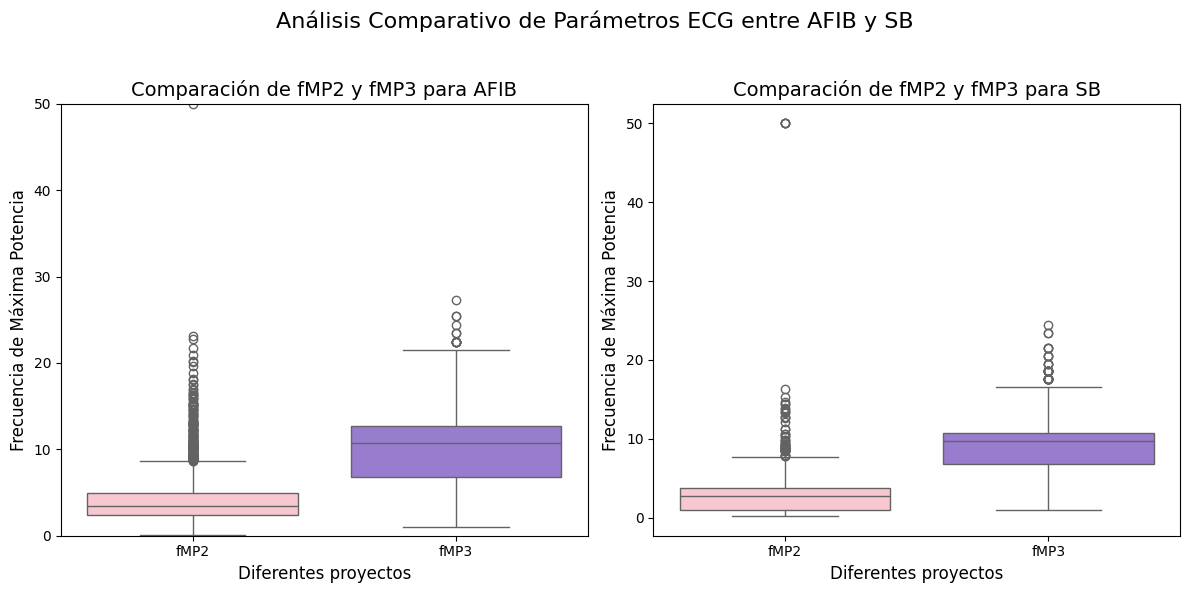

In [52]:
plt.figure(figsize=(12, 6))  # Tamaño ajustado para acomodar dos gráficos uno al lado del otro

# Preparar los datos para AFIB y SB
data_afib = df_merged[df_merged['Patología'] == 'AFIB'].melt(id_vars=['Patología'], value_vars=['fMP2', 'fMP3'])
data_sb = df_merged[df_merged['Patología'] == 'SB'].melt(id_vars=['Patología'], value_vars=['fMP2', 'fMP3'])

# Gráfico 1: Boxplot de fMP2 y fMP3 para AFIB
plt.subplot(1, 2, 1)  # Primer gráfico en una figura con dos subplots
sns.boxplot(x='variable', y='value', hue='variable', data=data_afib, palette=['pink', 'mediumpurple'], legend=False)
plt.title('Comparación de fMP2 y fMP3 para AFIB', fontsize=14)
plt.suptitle('Análisis Comparativo de Parámetros ECG entre AFIB y SB', fontsize=16)
plt.ylabel('Frecuencia de Máxima Potencia', fontsize=12)
plt.xlabel('Diferentes proyectos', fontsize=12)
plt.ylim(0, 50)

# Gráfico 2: Boxplot de fMP2 y fMP3 para SB
plt.subplot(1, 2, 2)  # Segundo gráfico
sns.boxplot(x='variable', y='value', hue='variable', data=data_sb, palette=['pink', 'mediumpurple'], legend=False)
plt.title('Comparación de fMP2 y fMP3 para SB', fontsize=14)
plt.ylabel('Frecuencia de Máxima Potencia', fontsize=12)
plt.xlabel('Diferentes proyectos', fontsize=12)

# Ajustar el layout
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar los gráficos
plt.show()

El análisis presentado en los gráficos muestra una comparación entre las frecuencias de máxima potencia (fMP2 y fMP3) para señales ECG de pacientes con fibrilación auricular (AFIB) y bradicardia sinusal (SB), utilizando dos enfoques distintos de procesamiento. Al observar el boxplot para las señales de AFIB (izquierda), se aprecia que las frecuencias de máxima potencia derivadas de este proyecto (fMP3) tienden a ser más altas en comparación con las obtenidas en el artículo de referencia utilizadas en el proyecto 2 (fMP2). Además, el rango intercuartílico es más amplio para fMP3, lo que indica una mayor variabilidad en las frecuencias tras el nuevo proceso de filtrado, posiblemente sugiriendo que el filtrado aplicado en este proyecto captura componentes de frecuencia que no fueron detectados con el enfoque original del artículo. De manera similar, en el análisis de las señales de bradicardia sinusal (SB) (derecha), se observa que las frecuencias de máxima potencia para fMP3 son generalmente más elevadas que para fMP2, y aunque la dispersión de los datos es mayor, esto indica que el nuevo flujo de filtrado no solo preserva componentes importantes de la señal sino que también puede estar realzando detalles frecuenciales que antes no se tenían en cuenta. Cabe destacar que, en ambos casos, la distribución de fMP3 tiene una mayor mediana y una mayor concentración de valores en el rango superior, lo que podría estar relacionado con una mejor resolución en las frecuencias más altas debido al nuevo enfoque de filtrado. Esto podría indicar que, aunque el filtrado realizado en este proyecto difiere del proceso empleado en el artículo de referencia, podría estar proporcionando una mayor sensibilidad para detectar variaciones en las señales ECG, en este caso, para pacientes con AFIB y SB. Sin embargo, la mayor variabilidad observada en fMP3 también podría significar que estas diferencias estarían relacionadas con mejoras en la detección de patrones clínicamente relevantes o si se podrían estar introduciendo artefactos no deseados que podrían influir en la interpretación.

In [53]:
import scipy.stats as stats

# Nivel de significancia (alpha)
alpha = 0.05

# Filtrar los datos por grupos SB y AFIB
sb_data_fmp2 = df_merged[df_merged['Patología'] == 'SB']['fMP2']
sb_data_fmp3 = df_merged[df_merged['Patología'] == 'SB']['fMP3']

afib_data_fmp2 = df_merged[df_merged['Patología'] == 'AFIB']['fMP2']
afib_data_fmp3 = df_merged[df_merged['Patología'] == 'AFIB']['fMP3']

# Prueba de normalidad Kolmogorov-Smirnov para fMP (SB y AFIB)
ks_stat_sb_fmp2, p_value_sb_fmp2 = stats.kstest(sb_data_fmp2, 'norm')
ks_stat_sb_fmp3, p_value_sb_fmp3 = stats.kstest(sb_data_fmp3, 'norm')

# Prueba de normalidad Kolmogorov-Smirnov para sFSB (SB y AFIB)
ks_stat_afib_fmp2, p_value_afib_fmp2 = stats.kstest(afib_data_fmp2, 'norm')
ks_stat_afib_fmp3, p_value_afib_fmp3 = stats.kstest(afib_data_fmp3, 'norm')

# Función para interpretar los resultados según las hipótesis del usuario
def interpretar_resultado(p_value, variable, estado):
    if p_value > alpha:
        print(f"No se puede rechazar H0 para {variable} en {estado}: Los datos distribuyen normal (p-valor = {p_value:.4f})")
    else:
        print(f"Se rechaza H0 para {variable} en {estado}: Los datos no distribuyen normal (p-valor = {p_value:.4f})")

# Interpretación de los resultados para fMP
interpretar_resultado(p_value_sb_fmp2, 'fMP2', 'SB')
interpretar_resultado(p_value_sb_fmp3, 'fMP3', 'SB')

# Interpretación de los resultados para sFSB
interpretar_resultado(p_value_afib_fmp2, 'fMP2', 'AFIB')
interpretar_resultado(p_value_afib_fmp3, 'fMP3', 'AFIB')


Se rechaza H0 para fMP2 en SB: Los datos no distribuyen normal (p-valor = 0.0000)
Se rechaza H0 para fMP3 en SB: Los datos no distribuyen normal (p-valor = 0.0000)
Se rechaza H0 para fMP2 en AFIB: Los datos no distribuyen normal (p-valor = 0.0000)
Se rechaza H0 para fMP3 en AFIB: Los datos no distribuyen normal (p-valor = 0.0000)


Se realizó la prueba de Shapiro-Wilk en las características de la Frecuencia de Máxima Potencia (fMP) para los resultados obtenidos en cada proyecto y a su vez para cada enfermedad (BS y AFIB). Los resultados mostraron que en todos los casos el p-valor fue 0.0000, lo que indica que las distribuciones de estas variables no siguen una distribución normal. La falta de normalidad en los datos hace necesario el uso de pruebas paramétricas convencionales, como la prueba t de Student o ANOVA, las cuales asumen que los datos deben distribuirse normalmente. Por lo tanto, se optó por aplicar pruebas no paramétricas.

In [54]:
# Prueba de Levene para fMP
levene_stat_fmp_sb, p_value_fmp_sb = stats.levene(sb_data_fmp2, sb_data_fmp3)
print(f"Resultado de la prueba de Levene para fMP (SB):")
print(f"Estadístico = {levene_stat_fmp_sb}, p-valor = {p_value_fmp_sb}")
if p_value_fmp_sb > alpha:
    print(f"No se puede rechazar H0: Las varianzas de fMP (SB) son iguales (p-valor = {p_value_fmp_sb:.4f})")
else:
    print(f"Se rechaza H0: Las varianzas de fMP (SB) no son iguales (p-valor = {p_value_fmp_sb:.4f})")

# Prueba de Levene para sFSB
levene_stat_fmp_afib, p_value_fmp_afib = stats.levene(afib_data_fmp2, afib_data_fmp3)
print(f"\nResultado de la prueba de Levene para fMP (AFIB):")
print(f"Estadístico = {levene_stat_fmp_afib}, p-valor = {p_value_fmp_afib}")
if p_value_fmp_afib > alpha:
    print(f"No se puede rechazar H0: Las varianzas de fMP (AFIB) son iguales (p-valor = {p_value_fmp_afib:.4f})")
else:
    print(f"Se rechaza H0: Las varianzas de fMP (AFIB) no son iguales (p-valor = {p_value_fmp_afib:.4f})")

Resultado de la prueba de Levene para fMP (SB):
Estadístico = 478.12749671767017, p-valor = 6.561385819323998e-103
Se rechaza H0: Las varianzas de fMP (SB) no son iguales (p-valor = 0.0000)

Resultado de la prueba de Levene para fMP (AFIB):
Estadístico = 197.80959085669028, p-valor = 9.143160321969143e-44
Se rechaza H0: Las varianzas de fMP (AFIB) no son iguales (p-valor = 0.0000)


Se utilizó la prueba de Levene para determinar si las varianzas de fMP entre ambos proyectos eran iguales entre los grupos de BS y AFIB. Los resultados mostraron que las varianzas en ambas características no son iguales, ya que los p-valores fueron 0.0000 en todos los casos. Esto indica una falta de homocedasticidad, lo cual refuerza la necesidad de utilizar pruebas no paramétricas, dado que muchas pruebas paramétricas también requieren la igualdad de varianza entre los grupos como supuesto fundamental.

In [55]:
# Prueba de Mann-Whitney para SB
mw_stat_fmp_sb, p_value_fmp_sb = stats.mannwhitneyu(sb_data_fmp2, sb_data_fmp3, alternative='two-sided')
print(f"Resultado de la prueba U de Mann-Whitney para fMP (SB):")
print(f"Estadístico = {mw_stat_fmp_sb}, p-valor = {p_value_fmp_sb}")
if p_value_fmp_sb > alpha:
    print(f"No se puede rechazar H0: No hay diferencias en la tendencia central de SB entre fMP2 y fMP3 (p-valor = {p_value_fmp_sb:.4f})")
else:
    print(f"Se rechaza H0: Hay diferencias en la tendencia central de de SB entre fMP2 y fMP3 (p-valor = {p_value_fmp_sb:.4f})")

# Prueba de Mann-Whitney para AFIB
mw_stat_fmp_afib, p_value_fmp_afib = stats.mannwhitneyu(afib_data_fmp2, afib_data_fmp3, alternative='two-sided')
print(f"\nResultado de la prueba U de Mann-Whitney para fMP (AFIB):")
print(f"Estadístico = {mw_stat_fmp_afib}, p-valor = {p_value_fmp_afib}")
if p_value_fmp_afib > alpha:
    print(f"No se puede rechazar H0: No hay diferencias en la tendencia central de AFIB entre fMP2 y fMP3 (p-valor = {p_value_fmp_afib:.4f})")
else:
    print(f"Se rechaza H0: Hay diferencias en la tendencia central de AFIB entre fMP2 y fMP3 (p-valor = {p_value_fmp_afib:.4f})")

Resultado de la prueba U de Mann-Whitney para fMP (SB):
Estadístico = 1182898.0, p-valor = 0.0
Se rechaza H0: Hay diferencias en la tendencia central de de SB entre fMP2 y fMP3 (p-valor = 0.0000)

Resultado de la prueba U de Mann-Whitney para fMP (AFIB):
Estadístico = 673411.0, p-valor = 3.498667217718916e-194
Se rechaza H0: Hay diferencias en la tendencia central de AFIB entre fMP2 y fMP3 (p-valor = 0.0000)


# **10.** Discución de diferencias entre los tipos de señales con el flujo de procesamiento propuesto respecto al que se trabajó en el proyecto 2

Los resultados obtenidos de la prueba U de Mann-Whitney para comparar las frecuencias de máxima potencia (fMP2 y fMP3) en señales ECG de pacientes con bradicardia sinusal (SB) y fibrilación auricular (AFIB) confirman la existencia de diferencias significativas entre los dos métodos de filtrado. En el caso de las señales SB, el estadístico de la prueba es 1,182,888.0 con un p-valor de 0.0, lo que indica que se rechaza la hipótesis nula (H0) de que no hay diferencias en la tendencia central entre fMP2 y fMP3. Esto significa que el proceso de filtrado aplicado en este proyecto produce un conjunto de frecuencias significativamente distinto al obtenido en el artículo de referencia.

De manera similar, para las señales de AFIB, el estadístico de la prueba es 673,411.0 con un p-valor extremadamente bajo (aproximadamente 3.49e-194). Esto también lleva al rechazo de la hipótesis nula, confirmando que existen diferencias significativas en la distribución central entre los dos enfoques de filtrado. El hecho de que ambos p-valores sean prácticamente cero indica que las diferencias entre fMP2 y fMP3 son altamente significativas para ambos tipos de señales (SB y AFIB).

Estos resultados cuantitativos respaldan el análisis gráfico anterior, donde se observó que fMP3 tiende a tener frecuencias de máxima potencia más altas y una mayor dispersión en comparación con fMP2. La prueba estadística confirma que el nuevo proceso de filtrado implementado en este proyecto no solo modifica la frecuencia de máxima potencia, sino que también introduce cambios significativos en la forma en que se distribuyen estas frecuencias en comparación con el enfoque del artículo. Esto sugiere que el filtrado actualizado podría estar capturando características frecuenciales adicionales o diferentes, lo cual podría ser beneficioso para el análisis clínico si estas nuevas frecuencias reflejan información relevante. Sin embargo, también es importante evaluar si estas diferencias representan mejoras en la detección de señales o si podrían corresponder a artefactos introducidos por el nuevo enfoque de filtrado.

#Conclusión

El análisis realizado confirmó que el Flujo 2 fue el más efectivo para mejorar la calidad de las señales ECG sin comprometer las componentes de interés, permitiendo la extracción de características relevantes como la frecuencia de máxima potencia. Las diferencias significativas encontradas entre los resultados obtenidos en este proyecto (fMP3) y el estudio previo (fMP2) sugieren que el nuevo método de filtrado podría mejorar la sensibilidad en la detección de componentes frecuenciales, especialmente en patologías como AFIB y SB.

Sin embargo, la mayor variabilidad observada en las frecuencias derivadas del nuevo flujo indica que, aunque se logra una mejor resolución, también se introducen diferencias que pueden no ser necesariamente beneficiosas. Esto indica que podría ser necesario una evaluación adicional para asegurarse de que las mejoras en la frecuencia no estén introduciendo artefactos que podrían sesgar el análisis.

Finalmente, puede decirse que el flujo de procesamiento propuesto logra un balance adecuado entre la eliminación de ruido y la preservación de las características esenciales del ECG. Sin embargo, para asegurar que estas diferencias reflejen mejoras en el diagnóstico y no anomalías introducidas por el proceso, sería necesario un análisis más detallado.

REFERENCIAS

[1] Cleveland, W. S., "Robust locally weighted regression and smoothing scatterplots," Journal of the American Statistical Association, vol. 74, no. 368, pp. 829-836, 1979.

[2] Buades, A., Coll, B., & Morel, J. M., "A non-local algorithm for image denoising," Proceedings of the 2005 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR), 2005.

[3] González, J. R., López, R., & Jaramillo, A. (2016). Las wavelets en el análisis de ECG. Scientia Et Technica, 21(3), 273-277. Universidad Tecnológica de Pereira. Disponible en: Redalyc.

[4] Gordan, C., & Reiz, R. ECG Signals Processing Using Wavelets. University of Oradea, Electronics Department, Faculty of Electrical Engineering and Information Technology, Oradea, Romania.

[5] iirfilter — SciPy v1.14.1 Manual. (s.f.). Numpy and Scipy Documentation — Numpy and Scipy documentation. https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html